In [2]:
import librosa
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import os
import glob
import pandas as pd

In [3]:
# Path to your data folder, where heart sound .wav files are stored in class-wise folders
data_path =  'Data'# Change this to your actual data path


data = {
    'Mitral Stenosis (MS)': [],  
    'Mitral Regurgitation (MR)': [],  
    'Mitral Valve Prolapse (MVP)': [],  
    'Aortic Stenosis (AS)': [],  
    'Normal': []  
}

In [4]:
def extract_features(file_path):
    features = []
    y, sr = librosa.load(file_path, sr=None)

    # Log Mel Spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spect = librosa.power_to_db(mel_spect)
    features.append(np.mean(log_mel_spect, axis=1))

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs, axis=1))

    # Delta and Delta-Delta (MFCC Derivatives)
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)
    features.append(np.mean(delta_mfcc, axis=1))
    features.append(np.mean(delta_delta_mfcc, axis=1))

    # Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(y, 'db1', level=5)
    features.append(np.hstack([np.mean(c) for c in coeffs]))

    # Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.append(np.mean(chroma, axis=1))

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features.append(np.mean(zcr))

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.append(np.mean(spectral_centroid))

    # Spectral Contrast with adjusted fmin
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, fmin=20.0)
    features.append(np.mean(spectral_contrast, axis=1))

    # Energy (RMS)
    rms = librosa.feature.rms(y=y)
    features.append(np.mean(rms))

    # Temporal Flatness (Spectral Flatness)
    flatness = librosa.feature.spectral_flatness(y=y)
    features.append(np.mean(flatness))

    return np.hstack(features)

In [5]:
for label in data.keys():
    folder = os.path.join(data_path, label)
    features_list = []
    for file in glob.glob(folder + "/*.wav"):
        features = extract_features(file)
        if features.size > 0:
            features_list.append(features)
        else:
            print(f"No features extracted for file: {file}")
    data[label] = np.array(features_list)  # Convert to NumPy array

print("Feature extraction completed.")

c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature extraction completed.


In [6]:
X = np.vstack([data['Aortic Stenosis (AS)'],
               data['Mitral Stenosis (MS)'],
               data['Mitral Regurgitation (MR)'],
               data['Mitral Valve Prolapse (MVP)'],
               data['Normal']])

y = np.concatenate([[0] * len(data['Aortic Stenosis (AS)']),
                    [1] * len(data['Mitral Stenosis (MS)']),
                    [2] * len(data['Mitral Regurgitation (MR)']),
                    [3] * len(data['Mitral Valve Prolapse (MVP)']),
                    [4] * len(data['Normal'])])

print(f"Shape of X (feature matrix): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


Shape of X (feature matrix): (1000, 196)
Shape of y (labels): (1000,)


In [15]:
# Ensure X_train and y_train are defined
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [31]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,                # Replace with the number of classes in your dataset
    eval_metric='mlogloss',     # Multiclass log-loss
    use_label_encoder=False,    # Suppress warning in newer versions
    max_depth=6,                # Depth of the trees
    eta=0.3,                    # Learning rate
    n_estimators=100            # Number of trees
)

In [35]:
model=clf.fit(X_train, y_train)

c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [37]:
y_pred = model.predict(X_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9873417721518988


In [16]:

# Number of iterations for Monte Carlo Cross-Validation
n_iterations = 10  # Number of MCCV iterations
accuracies = []
classification_reports = []


# Monte Carlo Cross-Validation
for i in range(n_iterations):
    print(f"Iteration {i+1}/{n_iterations}")
    
    # Randomly select a train-test split ratio between 0.6 and 0.9 for the train set
    train_size = np.random.uniform(0.6, 0.9)
    test_size = 1 - train_size
    
    print(f"Random Train-Test split for iteration {i+1}: Train Size = {train_size*100:.2f}%, Test Size = {test_size*100:.2f}%")
    
    # Step 1: Randomly split into training + test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i, stratify=y)
    
    # Step 2: Split the training data into training and validation sets (fixed ratio, e.g., 80-20)
    validation_size = 0.2  # Proportion of the training data used for validation
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=validation_size, random_state=i, stratify=y_train)
    
    # Train the XGBoost classifier
    clf = xgb.XGBClassifier(
        objective='multi:softmax',  # Multi-class classification
        num_class=5,                # 5 classes
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    
    clf.fit(X_train, y_train)  # Train the model
    
    # Step 3: Predict the test set
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # 
    report = classification_report(y_test, y_pred, target_names=[
        'Aortic Stenosis (AS)', 'Mitral Stenosis (MS)', 
        'Mitral Regurgitation (MR)', 'Mitral Valve Prolapse (MVP)', 
        'Normal'], output_dict=True)
    classification_reports.append(report)
    
    print(f"Accuracy for iteration {i+1}: {accuracy * 100:.2f}%")


mean_accuracy = np.mean(accuracies)
print(f"\nAverage accuracy over {n_iterations} iterations: {mean_accuracy * 100:.2f}%")

# Step 8: Calculate average precision for each class across iterations
class_precision = {class_name: np.mean([report[class_name]['precision'] for report in classification_reports]) 
                   for class_name in classification_reports[0].keys() if class_name != 'accuracy'}

print("\nAverage Precision per Class:")
for class_name, precision in class_precision.items():
    print(f"{class_name}: {precision:.4f}")







Iteration 1/10
Random Train-Test split for iteration 1: Train Size = 85.58%, Test Size = 14.42%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 1: 97.93%
Iteration 2/10
Random Train-Test split for iteration 2: Train Size = 62.80%, Test Size = 37.20%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 2: 97.04%
Iteration 3/10
Random Train-Test split for iteration 3: Train Size = 66.76%, Test Size = 33.24%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 3: 97.30%
Iteration 4/10
Random Train-Test split for iteration 4: Train Size = 85.85%, Test Size = 14.15%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 4: 97.89%
Iteration 5/10
Random Train-Test split for iteration 5: Train Size = 66.13%, Test Size = 33.87%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 5: 97.64%
Iteration 6/10
Random Train-Test split for iteration 6: Train Size = 62.00%, Test Size = 38.00%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 6: 95.54%
Iteration 7/10
Random Train-Test split for iteration 7: Train Size = 62.09%, Test Size = 37.91%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 7: 95.79%
Iteration 8/10
Random Train-Test split for iteration 8: Train Size = 62.77%, Test Size = 37.23%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 8: 97.86%
Iteration 9/10
Random Train-Test split for iteration 9: Train Size = 81.05%, Test Size = 18.95%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 9: 97.89%
Iteration 10/10
Random Train-Test split for iteration 10: Train Size = 68.49%, Test Size = 31.51%


c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy for iteration 10: 98.73%

Average accuracy over 10 iterations: 97.36%

Average Precision per Class:
Aortic Stenosis (AS): 0.9626
Mitral Stenosis (MS): 0.9802
Mitral Regurgitation (MR): 0.9620
Mitral Valve Prolapse (MVP): 0.9879
Normal: 0.9779
macro avg: 0.9741
weighted avg: 0.9741


In [17]:
y_pred = clf.predict(X_test)

In [18]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    'Aortic Stenosis (AS)', 'Mitral Stenosis (MS)', 
    'Mitral Regurgitation (MR)', 'Mitral Valve Prolapse (MVP)', 
    'Normal']))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
                             precision    recall  f1-score   support

       Aortic Stenosis (AS)       1.00      0.95      0.98        63
       Mitral Stenosis (MS)       1.00      1.00      1.00        63
  Mitral Regurgitation (MR)       0.95      1.00      0.98        63
Mitral Valve Prolapse (MVP)       0.98      0.98      0.98        63
                     Normal       1.00      1.00      1.00        64

                   accuracy                           0.99       316
                  macro avg       0.99      0.99      0.99       316
               weighted avg       0.99      0.99      0.99       316

Accuracy: 98.73%


In [19]:
# %% Train XGBoost Classifier
clf = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,                # We have 5 classes
    eval_metric='mlogloss',
    use_label_encoder=False
)

In [20]:
y_check=clf.fit(X_train, y_train)

c:\Users\pasar\anaconda3\envs\Heart\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                             precision    recall  f1-score   support

       Aortic Stenosis (AS)       1.00      1.00      1.00       109
       Mitral Stenosis (MS)       1.00      1.00      1.00       110
  Mitral Regurgitation (MR)       1.00      1.00      1.00       109
Mitral Valve Prolapse (MVP)       1.00      1.00      1.00       110
                     Normal       1.00      1.00      1.00       109

                   accuracy                           1.00       547
                  macro avg       1.00      1.00      1.00       547
               weighted avg       1.00      1.00      1.00       547



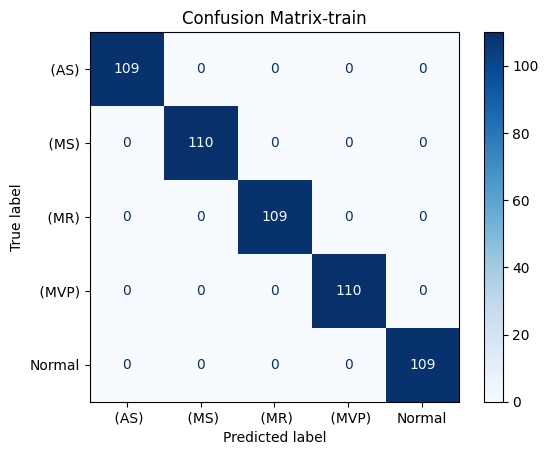

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Performance metrics
y_check_pred = clf.predict(X_train)

print("Classification Report:")
report = classification_report(y_train, y_check_pred, target_names=[
    'Aortic Stenosis (AS)', 'Mitral Stenosis (MS)', 
    'Mitral Regurgitation (MR)', 'Mitral Valve Prolapse (MVP)', 
    'Normal'])
print(report)

# Confusion Matrix
cm = confusion_matrix(y_train, y_check_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
    ' (AS)', ' (MS)', 
    ' (MR)', ' (MVP)', 
    'Normal'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix-train")
plt.show()